<a href="https://colab.research.google.com/github/coda-nsit/kaggle/blob/master/Autoencoder_iFood_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There is too much variation in the data hence we need use **autoencoders** to encode the images into a lower dimensional space. 

Autoencoders also result in more expressive representations.

So the output of the autoencoder is fed to finetune the inception model.

https://www.kaggle.com/marlesson/autoencoder-embedding-for-food

In [0]:
import numpy as np 
import pandas as pd 
import missingno as msno
import matplotlib.pyplot as plt
import os

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Layer, Add, Multiply, Flatten, Reshape, Conv2DTranspose
from keras.models import Model, Sequential
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

import argparse
import os

Using TensorFlow backend.


In [0]:
!pip uninstall keras
!pip install keras==2.2.4

Uninstalling Keras-2.2.5:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.2.5.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.2.5
     |████████████████████████████████| 317kB 3.5MB/s 


# Load the data

In [0]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!ls
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle

kaggle.json  sample_data


In [0]:
%%capture
!kaggle competitions download -c ifood-2019-fgvc6

In [0]:
!unzip -q train_set.zip
!unzip -q train_labels.csv.zip

In [0]:
!unzip -q val_set.zip
!unzip -q test_set.zip

# Preprocessing of the input data

In [0]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
                rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
sample = 6000

df_train = pd.read_csv('/content/train_labels.csv')
df_val   = pd.read_csv('/content/val_labels.csv')

# convert class to string
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)

df_train.head()

df_train = df_train.sample(sample) 
df_val  = df_val.sample(sample)

df_train.shape, df_val.shape

((6000, 2), (6000, 2))

In [0]:
batch_size  = 36

train_generator = train_datagen.flow_from_dataframe(
                df_train,
                x_col='img_name',
                y_col='label',    
                class_mode='input',
                directory='/content/train_set/',  # this is the target directory
                shuffle = True,
                target_size=(256, 256),  # all images will be resized to 150x150
                batch_size=batch_size)   # since we use binary_crossentropy loss, we need binary labels

test_generator = test_datagen.flow_from_dataframe(
                df_val,
                x_col='img_name',
                y_col='label',    
                class_mode='input',
                directory='/content/val_set/',  # this is the target directory
                shuffle = False,
                target_size=(256, 256),  # all images will be resized to 150x150
                batch_size=batch_size)  # since we use binary_crossentropy loss, we need binary labels


# Predict train 
train_generator_inf = test_datagen.flow_from_dataframe(
                        df_train,
                        x_col='img_name',
                        y_col='label',    
                        class_mode='input',
                        directory='/content/train_set/',  # this is the target directory
                        shuffle = False,
                        target_size=(256, 256),  # all images will be resized to 150x150
                        batch_size=batch_size)  # since we use binary_crossentropy loss, we need binary labels

Found 6000 validated image filenames.
Found 6000 validated image filenames.
Found 6000 validated image filenames.


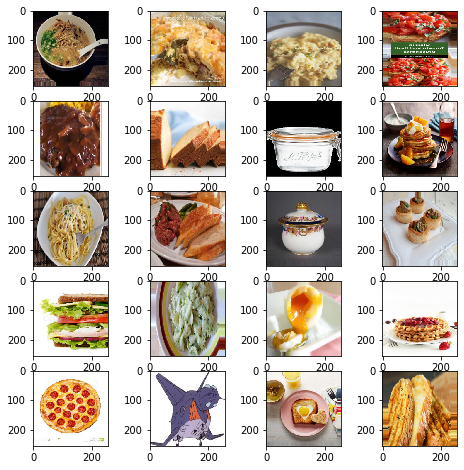

In [0]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns * rows + 1):
    img = train_generator.next()[0][0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Autoencoder Setup

In [0]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [0]:
image_size  = 256
input_shape = (image_size, image_size, 3)
batch_size  = 36
epochs      = 3

kernel_size = 3
filters     = 16
latent_dim  = 128


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters, kernel_size=kernel_size,
               activation='relu', strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean    = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z_mean, z_log_var = KLDivergenceLayer()([z_mean, z_log_var])

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
print("Encoder")
encoder.summary()
#plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,
                        activation='relu', strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size, activation='sigmoid',
                          padding='same', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
print("Decoder")
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])

# VAE
vae = Model(inputs, outputs, name='vae')
print("VAE")
vae.summary()

Encoder
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 32) 896         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 64)   18496       conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 262144)       0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
de

In [0]:
# reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss *= image_size * image_size
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = K.sum(kl_loss, axis=-1)
# kl_loss *= -0.5
# vae_loss2 = K.mean(reconstruction_loss + kl_loss)

# def vae_loss(x, x_decoded_mean):
#     xent_loss = binary_crossentropy(x, x_decoded_mean)
#     kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     return xent_loss + kl_loss

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    lh = K.tf.distributions.Bernoulli(probs=y_pred)

    return - K.sum(lh.log_prob(y_true), axis=-1)

In [0]:
vae.compile(optimizer='adam', loss=nll)

In [0]:
filepath       = "base-vae-weights.hdf5"
checkpoint     = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [0]:
hist = vae.fit_generator(train_generator,
                        steps_per_epoch=len(train_generator),
                        validation_data=test_generator,
                        validation_steps=len(test_generator),
                        callbacks=callbacks_list,                                 
                        epochs=epochs)

Epoch 1/3
167/167 [==============================] - 1355s 8s/step - loss: 2.0349 - val_loss: 2.0205

Epoch 00001: val_loss improved from inf to 2.02053, saving model to base-vae-weights.hdf5
Epoch 2/3
167/167 [==============================] - 1286s 8s/step - loss: 2.0245 - val_loss: 2.0176

Epoch 00002: val_loss improved from 2.02053 to 2.01762, saving model to base-vae-weights.hdf5
Epoch 3/3
 34/167 [=====>........................] - ETA: 13:23 - loss: 2.0219

In [0]:
# encoder, from inputs to latent space
encoder = Model(inputs, z)

NameError: ignored

In [0]:
def predict_generator(model, gen):
    # Predict latent-space map
    pred_maps = encoder.predict_generator(test_generator,steps = len(test_generator))
    # Predict latent-space vector
    #mean, var, z = np.array(pred_maps)
    return pred_maps

In [0]:
# Predict latent-space vector
pred_enb = predict_generator(encoder, test_generator)
pred_enb.shape

NameError: ignored

# Visualize the vae results

In [0]:
imgs      = train_generator.next()[0]
imgs_pred = vae.predict(imgs)

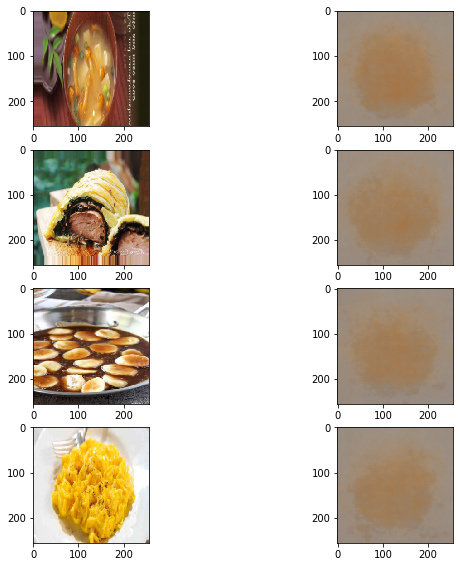

In [0]:
def plot_images(imgs, imgs_pred):
    fig=plt.figure(figsize=(10, 20))
    columns = 2
    rows    = 8

    for i in range(1, 9, 2):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
        
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(imgs_pred[i])
    plt.show()
plot_images(imgs, imgs_pred)

# Save the embeddings

In [0]:
# train
train_enb    = predict_generator(encoder, train_generator_inf)
df_emb_train = pd.DataFrame(train_enb)
df_emb_train['img_name'] = df_train.img_name.values

# Val
val_enb    = pred_enb#predict_generator(encoder, test_generator)
df_emb_val = pd.DataFrame(val_enb)
df_emb_val['img_name'] = df_val.img_name.values

df_emb_train.shape, df_emb_val.shape

NameError: ignored

In [0]:
df_emb_train.to_csv('df_vae_emb_train.csv')
df_emb_val.to_csv('df_vae_emb_val.csv')

In [0]:
df_emb_val.head()

In [0]:
input_img = Input(shape=(256, 256, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((4, 4), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((4, 4))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         1160      
________________________

In [0]:
# Save best model
from keras.callbacks import TensorBoard

filepath       = "base-weights.hdf5"
checkpoint     = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [0]:
# train the autoencoder
hist = autoencoder.fit_generator(train_generator,
                                steps_per_epoch=len(train_generator),
                                validation_data=test_generator,
                                validation_steps=len(test_generator),
                                callbacks=callbacks_list,                                 
                                epochs=epochs)




Epoch 1/50





 13/167 [=>............................] - ETA: 18:28 - loss: 0.6819

In [0]:
def plt_hist(hist):
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
plt_hist(hist)